# ML in Cybersecurity: Project III

## Team
  * **Team name**:  MMM
  * **Members**:  Maria Sargsyan (2576831,msargsyan@mpi-inf.mpg.de), Muneeb Aadil (2581794, maadil@mpi-inf.mpg.de), Muhammad Yaseen (2577833, myaseen@mpi-inf.mpg.de).
  * **Tutor**: *???*


## Logistics
  * **Due date**: 12th December 2019, 13:59:59 
  * Email the completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 28-Nov-2019: Project 3 hand-out
  * **12-Dec-2019** (13:59:59): Email completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland

  * 19-Dec-2019: Project 3 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset


# Debugging
import pdb

In [2]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [3]:
def identity_func(foo):
    return foo

def data_to_arrays(data):
    out1 = []
    out2 = []
    for d in data:
        x, y = d
        out1.append(x)
        out2.append(y)
    out1 = torch.cat(out1, dim=0)
    out2 = torch.IntTensor(out2)
    return out1, out2

class IncorrectPrediction:
    def __init__(self, true_label, predicted_label, image, prob_dist):
        self.true_label = true_label
        self.predicted_label = predicted_label
        self.image = image
        self.prob_dist = prob_dist
        
def get_accuracy_from_predictions(actual, predictions, verbose=False):

    assert actual.size() == predictions.size()
    incorrect = torch.sum(predictions != actual).item()
    total = float(actual.size()[0])
    acc = 1 - (incorrect / total)
    if verbose: 
      print('{0} predictions not correct from a total of {1}'.format(incorrect, total))
      print('Accuracy: {0}%'.format(acc*100))
    
    return acc

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

#### 1.1.1.1: Loading MNIST Data

Load and process MNIST data

In [4]:
# Loading MNIST data
BATCH_SIZE = 4
VALIDATION_FRACTION = 0.1
EPOCHS = 2
CLASSES = [str(i) for i in range(0,10)]

tsfms = transforms.Compose([
    transforms.ToTensor(),  # data loader returns a PIL image, we need to transform it to a Tensor object
])

# train and test datasets, transformed to a tensor
mnist_train_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=True, transform=tsfms)
mnist_val_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=True, transform=tsfms)
mnist_test_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=False, transform=tsfms)

# we need to create a disjoint validation set from within the training set
# following the approach taken in this link
# https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb

num_training = len(mnist_train_data)
all_indices = list(range(num_training)) # this gives us indices over the whole training set
split = int(np.floor( VALIDATION_FRACTION * num_training))
# split indices into disjoint sets
train_indices, val_indices = all_indices[split:], all_indices[:split]

# now we have the indices for train and val sets, we create a pytorch 
# custom sampler over both datasets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# represents a data loader, takes care of random batching and indexing etc.
mnist_train_data_loader = torch.utils.data.DataLoader(mnist_train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
mnist_val_data_loader   = torch.utils.data.DataLoader(mnist_val_data, batch_size=BATCH_SIZE, sampler=val_sampler)
mnist_test_data_loader  = torch.utils.data.DataLoader(mnist_test_data, batch_size=BATCH_SIZE, shuffle=False)

#### 1.1.1.2: Defining the Model

Define the CNN Model

In [5]:
# Model represented as class

class CNNModel(nn.Module):

    def __init__(self):
    
        super(CNNModel, self).__init__()

        ## formula to make sure params work out
        ## W_out = (W_in - F)/S + 1
        ## from http://cs231n.github.io/convolutional-networks/

        ## we will have 2 conv layers

        # in_channel is 1 bcz MNIST is a BW dataset
        # from 1 input, we create 6 output feature maps, using 5x5 kernels
        # input is 28x28, output will be 24x24
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

        # max pool over the 2x2 region.
        # input is 24x24, output will be 12x12 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # after max pool, out spatial dim is reduced, but num channels coming from 
        # prev conv1 is still 6. We create 16 feature maps, again using 5x5 kernels
        # input is 12x12, output will be 8x8
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # max pool over the 2x2 region. 
        # input is 8x8, output will be 4x4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        ## followed by 2 FC layers, y = Wx + b
        # we take features computer after the pool2 step.
        # we have 16 maps, each of size 4x4. We will flatten them
        self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        ## and a last FC layer for predictions
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    # we define the fwd pass, backward pass is automatically defined 
    # by PyTorch thru lineage

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # flatten
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.tanh(self.fc1(x))
        #x = F.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

In [6]:
# Function to test the model on a give (sub)set.

def test_model(cnn_model, is_test_set=False, verbose=False):

    class_preds = []
    ground_truth = []
    incorrect_predictions = []
    TEST = is_test_set


    with torch.no_grad():
        for data in mnist_test_data_loader if TEST else mnist_val_data_loader:
            images, labels = data

            # get (unnormalized) predictions
            predictions = cnn_model(images)
            # normalize to get probability distribution
            batch_class_probabilities = [F.softmax(el, dim=0) for el in predictions]
            # get index of max value which corresponds to the predicted label
            # we discard actual values because they are of no use as we use 
            # probability dist
            _, predicted_labels = torch.max(predictions, 1)

            # we save some of the incorrect predictions to view them later for 
            # insights and reasoning
            for i,(t,p) in enumerate(zip(labels.tolist(),predicted_labels.tolist())):
                if t != p:
                    incorrect_predictions.append(IncorrectPrediction(t,p,images[i],batch_class_probabilities[i]))

            ground_truth.append(labels)
            #class_probs.append(batch_class_probabilities)
            class_preds.append(predicted_labels)

    # concat predictions from all batches to get a single vector
    test_preds = torch.cat(class_preds)
    # actual labels
    ground_truth = torch.cat(ground_truth)
    # calculate accuracy in percentage given predictions and ground truth
    accuracy = get_accuracy_from_predictions(ground_truth, test_preds, verbose=verbose)

    return accuracy, incorrect_predictions

#### 1.1.1.3: Defining the Loss function, Optimization, and Training Loop

In [8]:
# initialize an instance of CNN model
cnn_model = CNNModel()

# automatically takes care of one-hot encoding the labels 
# https://pytorch.org/docs/stable/nn.html#crossentropyloss
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

running_loss = 0.0
val_acc_history = []
loss_history = []

best_model = None
best_val_acc = None
# the training loop
for epoch in range(EPOCHS):

    print("Epoch [{} / {}]".format(epoch+1, EPOCHS))
    for i, data in tqdm(enumerate(mnist_train_data_loader, 0)):

        inputs, labels = data
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 1000 == 999:
            loss_per_1k = running_loss / 1000.0
            loss_history.append(loss_per_1k)
            
            val_acc, _ = test_model(cnn_model, is_test_set=False)
            val_acc_history.append(val_acc)
            
            print("Loss: {0} \t Validation Accuracy: {1}%".format(str(loss_per_1k), str(val_acc*100)))
            
            running_loss = 0.0

print("Finished training")

12it [00:00, 119.68it/s]

Epoch [1 / 2]


1035it [00:07, 39.65it/s]

Loss: 2.2925119276046755 	 Validation Accuracy: 35.03333333333334%


2023it [00:13, 46.34it/s] 

Loss: 1.303448153734207 	 Validation Accuracy: 86.05000000000001%


3033it [00:21, 35.18it/s] 

Loss: 0.3994102317581419 	 Validation Accuracy: 89.08333333333334%


4035it [00:28, 35.78it/s] 

Loss: 0.25156671786110385 	 Validation Accuracy: 91.51666666666667%


5040it [00:35, 40.45it/s] 

Loss: 0.21993667335860664 	 Validation Accuracy: 95.48333333333333%


6036it [00:42, 44.94it/s] 

Loss: 0.17235561320165288 	 Validation Accuracy: 95.35%


7027it [00:49, 36.45it/s] 

Loss: 0.16378340476783343 	 Validation Accuracy: 95.78333333333333%


8029it [00:57, 37.77it/s] 

Loss: 0.15277662349298043 	 Validation Accuracy: 96.21666666666667%


9038it [01:03, 43.97it/s] 

Loss: 0.13911449413079754 	 Validation Accuracy: 96.51666666666667%


10024it [01:11, 38.07it/s]

Loss: 0.12468976062612819 	 Validation Accuracy: 96.41666666666666%


11013it [01:19, 26.40it/s] 

Loss: 0.14390355501724844 	 Validation Accuracy: 96.61666666666666%


12017it [01:27, 36.57it/s] 

Loss: 0.113533977975374 	 Validation Accuracy: 96.88333333333333%


13033it [01:35, 37.77it/s] 

Loss: 0.11552555323462002 	 Validation Accuracy: 97.26666666666667%


13500it [01:37, 137.99it/s]
18it [00:00, 178.35it/s]

Epoch [2 / 2]


1022it [00:07, 31.84it/s]

Loss: 0.1413921309005218 	 Validation Accuracy: 96.96666666666667%


2035it [00:15, 30.11it/s] 

Loss: 0.0965918412666947 	 Validation Accuracy: 96.71666666666667%


3024it [00:23, 30.23it/s] 

Loss: 0.08883648239463218 	 Validation Accuracy: 97.45%


4032it [00:31, 33.65it/s] 

Loss: 0.07473005053984616 	 Validation Accuracy: 96.38333333333333%


5048it [00:37, 49.18it/s] 

Loss: 0.09177948251963972 	 Validation Accuracy: 97.63333333333334%


6036it [00:45, 31.72it/s] 

Loss: 0.0908298755186861 	 Validation Accuracy: 97.48333333333333%


7021it [00:53, 35.84it/s] 

Loss: 0.0748659489994061 	 Validation Accuracy: 97.39999999999999%


8025it [01:00, 34.96it/s] 

Loss: 0.08257404863135526 	 Validation Accuracy: 97.55%


9024it [01:08, 34.95it/s] 

Loss: 0.08421517090662746 	 Validation Accuracy: 97.3%


10018it [01:15, 42.69it/s]

Loss: 0.07291248715660549 	 Validation Accuracy: 97.58333333333333%


11021it [01:21, 45.21it/s] 

Loss: 0.06632260187408838 	 Validation Accuracy: 97.93333333333334%


12037it [01:29, 37.68it/s] 

Loss: 0.0849970404582382 	 Validation Accuracy: 97.88333333333334%


13027it [01:37, 26.76it/s] 

Loss: 0.06762816906225862 	 Validation Accuracy: 97.81666666666666%


13500it [01:39, 135.16it/s]

Finished training


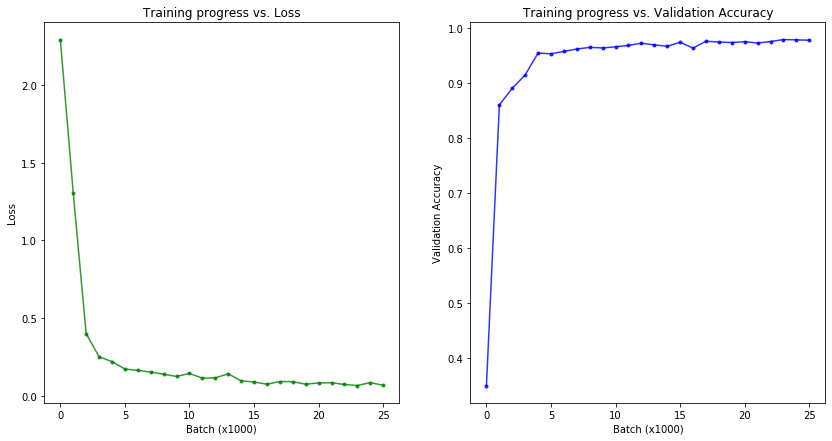

<Figure size 432x288 with 0 Axes>

In [14]:
# Visualize trainset performance

# plot loss curve per 1000 batches (per 4000 examples if BS = 4)
# Note: we didn't plot it against num_epochs because we didn't run many epochs as network 
# converges after 1 or 2. We thought it would be more interesting to see trends b/w batches.
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ax[0].plot(range(len(loss_history)), loss_history,  
         color='g', alpha=0.8, marker='.')
ax[0].set( 
    xlabel='Batch (x1000)', 
    ylabel='Loss', 
    title='Training progress vs. Loss')


# plot val acc per 1000 batches (per 4000 examples if BS = 4)
ax[1].plot(range(len(val_acc_history)), val_acc_history,  
         color='b', alpha=0.8, marker='.')
ax[1].set( 
    xlabel='Batch (x1000)', 
    ylabel='Validation Accuracy', 
    title='Training progress vs. Validation Accuracy')
plt.show()
plt.tight_layout()

#### 1.1.1.4: Evaluation

Before attacking the model, we need to make sure that it achieves >95% accuracy on test set.


In [16]:
accuracy, incorrect_predictions = test_model(cnn_model, is_test_set=True, verbose=False)
print('Accuracy on unseen test data is {0}%'.format(accuracy*100))

Accuracy on unseen test data is 97.94%


In [19]:
# save the trained model.
MODEL_SAVE_PATH = './victim-model.pth'
torch.save(cnn_model.cpu().state_dict(), MODEL_SAVE_PATH)

### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

In [7]:
def FGSM(model, Xtrue, Ytrue, criterion, epsilon=0.01, min_val=0, max_val=1):
    """
    Implements the one step FGSM attack.
    
    Args:
        
    Returns:
    """
    Xtrue.requires_grad = True # we use this for calculating gradients for image,
    # which is turned off by default.
    
    Ypred = model(Xtrue)
    _, pred_classes_before = torch.max(Ypred, dim=1)
    
    if pred_classes_before

    # TODO: generalize min_val and max_val variables.
    loss = criterion(Ypred, Ytrue)
    
    # calculate gradients
    model.zero_grad()
    loss.backward()
    
    # pdb.set_trace()
    
    with torch.no_grad():
        grad_sign = Xtrue.grad.data.sign()
        Xperturbed = Xtrue.data + (epsilon * grad_sign)
        Xperturbed = torch.clamp(Xperturbed, min=0, max=1)
        
        Ypred_ = model(Xperturbed)
        _, pred_classes_after = torch.max(Ypred_, dim=1)
        
    return Xperturbed, pred_classes_before, pred_classes_after

In [8]:
# load the trained model
MODEL_LOAD_PATH = './victim-model.pth'
victim_model = CNNModel().to(device)
victim_model.load_state_dict(torch.load(MODEL_LOAD_PATH))
victim_model.eval()

criterion = torch.nn.CrossEntropyLoss().to(device)

epsilons = np.linspace(0.01, 0.3, num=10)

In [9]:
for (Xtest, Ytest) in tqdm(mnist_test_data_loader):
    Xtest = Xtest.to(device)
    Ytest = Ytest.to(device)
    Yperturbed, preds_before, preds_after = FGSM(victim_model, Xtest, Ytest, criterion, epsilon=.3)

100%|██████████| 2500/2500 [00:15<00:00, 158.01it/s]


tensor([7, 2, 1, 0]) tensor([5, 5, 6, 6])


### 1.1.3: adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

In [0]:
#
#
# ------- Your Code -------
#
#

### 1.1.3: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

In [0]:
#
#
# ------- Your Code -------
#
#

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [0]:
#
#
# ------- Your Code -------
#
#

# (a) attack 1
# (b) attack 2

### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


In [0]:
#
#
# ------- Your Code -------
#
#

# template code (Please feel free to change this)
# (each column corresponds to one attack method)
col_titles = ['Ori','FGSM','Method 1', 'Method 2'] 
nsamples = 10
nrows = nsamples
ncols = len(col_titles)

fig, axes = plt.subplots(nrows,ncols,figsize=(8,12))  # create the figure with subplots
[ax.set_axis_off() for ax in axes.ravel()]  # remove the axis

for ax, col in zip(axes[0], col_titles): # set up the title for each column
    ax.set_title(col,fontdict={'fontsize':18,'color':'b'})

for i in range(nsamples):
    axes[i,0].imshow(images_ori[i])
    axes[i,1].imshow(adv_FGSM[i])
    axes[i,2].imshow(adv_Method1[i])
    axes[i,3].imshow(adv_Method2[i])
                  

Which differences do you observe when comparing different attack methods? Why?   
Please write a brief summary of your findings.   
* Does the attack always succeed (the model make wrong prediction on the adversarial sample)?
* How different is the adversarial sample from the original image?
(L0,L2,Linf norm)  
* How about the computation cost of each attack method?
* Does the attack require white-box access to the model?
* .....

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

In [0]:
#
#
# ------- Your Code -------
#
#
print('Accuracy on adversarial samples (FGSM) %.2f'%acc_FGSM)
print('Accuracy on adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend)

### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. 

* What did you try to make the classifier more robust against FGSM? 
* Why did it work? 
* Is the classifier now robust against FGSM?  
* ...

Feel free to state any interesting finding you encountered during this project.